# Fraud in Electricity and Gas Consumption #

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

from sklearn.metrics import fbeta_score, make_scorer, accuracy_score, roc_auc_score, precision_score, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
seed = 69


## Data Cleaning

### Since 2 datasets were provided, we attempt to combine both datasets into 1 on the id columm. ###

In [2]:
invoice_df = pd.read_csv('invoice.csv')
client_df = pd.read_csv('client.csv')

combined_df = pd.merge(client_df, invoice_df, on='id', how='left')



In [3]:
combined_df.head()

,region,date_x,dis,id,catg,target,date_y,tarif_type,counter_number,counter_statue,...,reading_remarque,consommation_level_4,old_index,new_index,months_number,counter_type,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3
0,101,31/12/1994,60,train_Client_0,11,0,24/3/2014,11,1335667.0,0,...,8,0,14302,14384,4,ELEC,1,82,0,0
1,101,31/12/1994,60,train_Client_0,11,0,29/3/2013,11,1335667.0,0,...,6,0,12294,13678,4,ELEC,1,1200,184,0
2,101,31/12/1994,60,train_Client_0,11,0,23/3/2015,11,1335667.0,0,...,8,0,14624,14747,4,ELEC,1,123,0,0
3,101,31/12/1994,60,train_Client_0,11,0,13/7/2015,11,1335667.0,0,...,8,0,14747,14849,4,ELEC,1,102,0,0
4,101,31/12/1994,60,train_Client_0,11,0,17/11/2016,11,1335667.0,0,...,9,0,15066,15638,12,ELEC,1,572,0,0


In [4]:
combined_df.describe()


,region,dis,catg,target,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,consommation_level_4,old_index,new_index,months_number,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3
count,500651.000000,500651.000000,500651.000000,500651.000000,500651.000000,5.006510e+05,500651.000000,500651.000000,500651.000000,500651.000000,5.006510e+05,5.006510e+05,500651.000000,500651.000000,500651.000000,500651.000000,500651.000000
mean,204.746922,63.519156,11.353871,0.062644,16.108279,1.951034e+11,0.050217,204.390755,7.463710,64.393150,1.575969e+04,1.639037e+04,22.744289,1.000154,443.065463,120.508706,28.196772
std,104.620488,3.388720,3.661420,0.242323,11.145881,2.071552e+12,0.396153,121.204514,1.374409,1230.465569,2.975733e+04,3.053707e+04,1670.624818,0.047150,592.249623,1396.817086,214.020756
min,101.000000,60.000000,11.000000,0.000000,9.000000,0.000000e+00,0.000000,5.000000,6.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000
25%,101.000000,62.000000,11.000000,0.000000,11.000000,1.477220e+05,0.000000,202.000000,6.000000,0.000000,1.799000e+03,2.165000e+03,4.000000,1.000000,99.000000,0.000000,0.000000
50%,107.000000,62.000000,11.000000,0.000000,11.000000,4.857010e+05,0.000000,203.000000,8.000000,0.000000,7.876000e+03,8.438000e+03,4.000000,1.000000,321.000000,0.000000,0.000000
75%,307.000000,69.000000,11.000000,0.000000,11.000000,1.008740e+06,0.000000,207.000000,9.000000,0.000000,2.092750e+04,2.164500e+04,4.000000,1.000000,661.000000,0.000000,0.000000
max,399.000000,69.000000,51.000000,1.000000,45.000000,2.740000e+13,5.000000,600.000000,9.000000,343568.000000,2.800280e+06,2.870972e+06,231602.000000,20.000000,98889.000000,819886.000000,45360.000000


In [5]:
combined_df.head()


,region,date_x,dis,id,catg,target,date_y,tarif_type,counter_number,counter_statue,...,reading_remarque,consommation_level_4,old_index,new_index,months_number,counter_type,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3
0,101,31/12/1994,60,train_Client_0,11,0,24/3/2014,11,1335667.0,0,...,8,0,14302,14384,4,ELEC,1,82,0,0
1,101,31/12/1994,60,train_Client_0,11,0,29/3/2013,11,1335667.0,0,...,6,0,12294,13678,4,ELEC,1,1200,184,0
2,101,31/12/1994,60,train_Client_0,11,0,23/3/2015,11,1335667.0,0,...,8,0,14624,14747,4,ELEC,1,123,0,0
3,101,31/12/1994,60,train_Client_0,11,0,13/7/2015,11,1335667.0,0,...,8,0,14747,14849,4,ELEC,1,102,0,0
4,101,31/12/1994,60,train_Client_0,11,0,17/11/2016,11,1335667.0,0,...,9,0,15066,15638,12,ELEC,1,572,0,0


In [6]:
print(f"Length of dataset: {len(combined_df)}")
print(f"Number of datapoints in each column: \n{combined_df.count()} \n")

Length of dataset: 500651
Number of datapoints in each column: 
region                  500651
date_x                  500651
dis                     500651
id                      500651
catg                    500651
target                  500651
date_y                  500651
tarif_type              500651
counter_number          500651
counter_statue          500651
counter_code            500651
reading_remarque        500651
consommation_level_4    500651
old_index               500651
new_index               500651
months_number           500651
counter_type            500651
counter_coefficient     500651
consommation_level_1    500651
consommation_level_2    500651
consommation_level_3    500651
dtype: int64 



In [7]:
number_of_fraud = sum(combined_df["target"] == 1)
print(number_of_fraud)
print(f"proportion of fraud: {number_of_fraud/len(combined_df)}")

31363
proportion of fraud: 0.06264443694310008


#### We have created 3 new variables, described as such:
##### delta_start_invoice: diff between join and transaction date
##### delta_index: diff between old and new index
##### delta_transactions: diff between transactions over the same client


In [8]:

dates = {'join_date': combined_df['date_x'], 'transaction_date': combined_df['date_y'], 'id': combined_df['id']}
dates_df = pd.DataFrame(dates)

dates_df['join_date'] = pd.to_datetime(dates_df['join_date'] , format='%d/%m/%Y')
dates_df['transaction_date'] = pd.to_datetime(dates_df['transaction_date'], format='%d/%m/%Y')

# Calculate the difference in days between transaction and join date
dates_df['delta_start_invoice'] = (dates_df['transaction_date']- dates_df['join_date']).dt.days

# Create new delta_transactions (diff between transaction dates for each client)
dates_df = dates_df.sort_values(['id', 'delta_start_invoice'])
dates_df['delta_transactions'] = dates_df.groupby('id')['delta_start_invoice'].diff().fillna(0)

dates_df.head()




,join_date,transaction_date,id,delta_start_invoice,delta_transactions
22,1994-12-31,2005-10-17,train_Client_0,3943,0.0
23,1994-12-31,2006-02-24,train_Client_0,4073,130.0
24,1994-12-31,2006-06-23,train_Client_0,4192,119.0
25,1994-12-31,2006-10-18,train_Client_0,4309,117.0
28,1994-12-31,2007-02-26,train_Client_0,4440,131.0


#### add new delta_start_invoice, delta_index and consommation_sum to combined_df

In [9]:
combined_df['delta_index'] = combined_df['new_index'] - combined_df['old_index']
combined_df['delta_start_invoice'] = dates_df['delta_start_invoice']
combined_df['delta_transactions'] = dates_df['delta_transactions']

#### new dataframe for one-hot encoding categorical variables (dis, catg, region, tarif_type, counter_statue, counter_code, reading_remarque, counter_type)

In [10]:
categorical_vars = ['dis', 'catg', 'region', 'tarif_type', 'counter_statue', 'counter_code', 'counter_type']
categorical_df = pd.get_dummies(combined_df, columns=categorical_vars, prefix=categorical_vars)
categorical_df = categorical_df.groupby('id').agg({col: 'max' for col in categorical_df.columns if col != 'id'})



#### Agg function to group the transactions with each client

In [11]:
stats = ['sum', 'mean', 'median', 'std']

selected_columns = ['consommation_level_1', 
                    'consommation_level_2', 'consommation_level_3', 'consommation_level_4',
                    'delta_index', 'delta_start_invoice', 'id', 'reading_remarque']

# Create a new dataframe with the desired aggregate functions
numerical_df = combined_df[selected_columns].groupby('id').agg(stats)

numerical_df.head()




consommation_level_1                                 \
                                   sum        mean median         std   
id                                                                      
train_Client_0                   12334  352.400000  267.0  310.343472   
train_Client_1                   20629  557.540541  520.0  197.935960   
train_Client_10                  14375  798.611111  655.5  513.841374   
train_Client_100                    24    1.200000    0.0    3.607011   
train_Client_1000                 9292  663.714286  770.0  224.831365   

                  consommation_level_2                                 \
                                   sum        mean median         std   
id                                                                      
train_Client_0                     370   10.571429    0.0   43.568935   
train_Client_1                       0    0.000000    0.0    0.000000   
train_Client_10                    682   37.888889    0.0  160.748942   
train_Client_100                     0    0.000000    0.0    0.000000   
train_Client_1000                 1468  104.857143    0.0  167.155320   

                  consommation_level_3              ... delta_index  \
                                   sum        mean  ...      median   
id                                                  ...               
train_Client_0                       0    0.000000  ...       267.0   
train_Client_1                       0    0.000000  ...       520.0   
train_Client_10                      0    0.000000  ...       655.5   
train_Client_100                     0    0.000000  ...         0.0   
train_Client_1000                 1643  117.357143  ...       770.0   

                              delta_start_invoice                       \
                          std                 sum         mean  median   
id                                                                       
train_Client_0     341.553930              213142  6089.771429  6047.0   
train_Client_1     197.935960              132603  3583.864865  3509.0   
train_Client_10    646.808386              165982  9221.222222  8678.0   
train_Client_100     3.607011               91275  4563.750000  4545.5   
train_Client_1000  633.485669               13497   964.071429  1010.0   

                               reading_remarque                             
                           std              sum      mean median       std  
id                                                                          
train_Client_0     1358.574709              244  6.971429    6.0  1.248192  
train_Client_1     1457.748762              267  7.216216    6.0  1.377097  
train_Client_10    1526.789733              127  7.055556    6.0  1.258955  
train_Client_100    774.520692              123  6.150000    6.0  0.670820  
train_Client_1000   506.611437              124  8.857143    9.0  0.363137  

[5 rows x 28 columns]

#### Combining numerical and cat dataframes

In [12]:
to_drop = ['region', 'date_x', 'dis', 'id', 'catg', 'target', 'date_y', 'tarif_type', 'counter_number', 
           'counter_statue', 'counter_code', 'reading_remarque', 'consommation_level_4', 'old_index',
           'new_index', 'months_number', 'counter_type', 'counter_coefficient', 'consommation_level_1',
           'consommation_level_2', 'consommation_level_3']

client_summary = pd.concat([numerical_df, categorical_df], axis=1)

# Identify existing columns in the DataFrame
existing_columns = [col for col in to_drop if col in client_summary.columns]

# Drop existing columns from the DataFrame
client_summary = client_summary.drop(columns=existing_columns)

client_summary.info()




<class 'pandas.core.frame.DataFrame'>
Index: 21652 entries, train_Client_0 to train_Client_128438
Columns: 116 entries, ('consommation_level_1', 'sum') to counter_type_GAZ
dtypes: bool(85), float64(22), int64(9)
memory usage: 7.0+ MB


#### Add y variable

In [13]:
client_summary['target'] = combined_df.groupby('id')['target'].apply(lambda x: 1 if x.any() else 0)
client_summary['target'].value_counts()


target
0    20576
1     1076
Name: count, dtype: int64

## Data Balancing

#### original split without data balancing

In [28]:

X = client_summary.drop('target', axis=1)

# Flatten multi-level column names
X.columns = [''.join(map(str, col)).strip() for col in X.columns.to_flat_index()]

y = client_summary['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= seed)

#### Due to the low proportion of fraud cases, we performed synthetic oversampling of fraud cases with SMOTE and undersampled non-fraud cases with Tomek's link with three different methods:
#### 1) SMOTE + Tomek's Link

In [47]:
# Define the oversampling strategy using SMOTE and Tomek
smote = SMOTE(sampling_strategy='auto')
smote = SMOTE(random_state=seed)
tomek = TomekLinks()


X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state= seed)


# under and oversampling of data using Tomek and SMOTE
X_train1, y_train1 = tomek.fit_resample(X_train1, y_train1)
X_train1, y_train1 = smote.fit_resample(X_train1, y_train1)


# Standardize the data separately to prevent leakage
scaler = StandardScaler()
X_train1_standardized = pd.DataFrame(scaler.fit_transform(X_train1), columns=X_train1.columns)
X_test1_standardized = pd.DataFrame(scaler.transform(X_test1), columns=X_test1.columns)

# Normalise the data
scaler_minmax = MinMaxScaler()
X_train1_normalized = pd.DataFrame(scaler_minmax.fit_transform(X_train1), columns=X_train1.columns)
X_test1_normmalized = pd.DataFrame(scaler_minmax.transform(X_test1), columns=X_test1.columns)



,consommation_level_1sum,consommation_level_1mean,consommation_level_1median,consommation_level_1std,consommation_level_2sum,consommation_level_2mean,consommation_level_2median,consommation_level_2std,consommation_level_3sum,consommation_level_3mean,...,counter_code_450,counter_code_453,counter_code_467,counter_code_483,counter_code_506,counter_code_532,counter_code_565,counter_code_600,counter_type_ELEC,counter_type_GAZ
0,0.685554,-0.221794,-0.425497,0.028572,-0.201780,-0.225311,-0.205524,-0.130865,-0.463374,-0.407162,...,-0.011142,-0.040972,-0.037811,-0.033906,-0.035255,-0.007879,-0.007879,-0.011142,0.048943,1.177256
1,0.796658,0.197327,0.244187,0.327422,-0.307390,-0.270927,-0.205524,-0.192952,-0.463374,-0.407162,...,-0.011142,-0.040972,-0.037811,-0.033906,-0.035255,-0.007879,-0.007879,-0.011142,0.048943,-0.849433
2,0.355386,0.140101,0.195116,-0.169480,-0.288245,-0.257144,-0.205524,-0.168790,-0.463374,-0.407162,...,-0.011142,-0.040972,-0.037811,-0.033906,-0.035255,-0.007879,-0.007879,-0.011142,0.048943,-0.849433
3,-0.961451,-0.663271,-0.561166,-0.373705,-0.307390,-0.270927,-0.205524,-0.192952,-0.463374,-0.407162,...,-0.011142,-0.040972,-0.037811,-0.033906,-0.035255,-0.007879,-0.007879,-0.011142,0.048943,-0.849433
4,-0.052457,-0.539388,-0.786319,0.036666,-0.272099,-0.253990,-0.205524,-0.140615,-0.368899,-0.366908,...,-0.011142,-0.040972,-0.037811,-0.033906,-0.035255,-0.007879,-0.007879,-0.011142,0.048943,1.177256


#### 2) SMOTE only

In [15]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=seed)

# Oversampling of data using SMOTE
X_train2, y_train2 = smote.fit_resample(X_train2, y_train2)

# Standardize the data separately to prevent leakage
scaler = StandardScaler()
X_train2_standardized = pd.DataFrame(scaler.fit_transform(X_train2), columns=X_train2.columns)
X_test2_standardized = pd.DataFrame(scaler.transform(X_test2), columns=X_test2.columns)

#### 3) SMOTE + ENN



In [16]:
# Define the ADASYN+ENN resampling strategy
smote_enn = SMOTEENN(random_state=seed)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.2, random_state=seed)

# Resampling of data using ADASYN+ENN
X_train3, y_train3 = smote_enn.fit_resample(X_train3, y_train3)

# Standardize the data separately to prevent leakage
scaler = StandardScaler()
X_train3_standardized = pd.DataFrame(scaler.fit_transform(X_train3), columns=X_train3.columns)
X_test3_standardized = pd.DataFrame(scaler.transform(X_test3), columns=X_test3.columns)

In [17]:
# Change Bool to int
for df in [X_train1_standardized, X_train2_standardized, X_train3_standardized,
           X_test1_standardized, X_test2_standardized, X_test3_standardized]:
    
    df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

In [18]:
for data in [X_train1_standardized, X_train2_standardized, X_train3_standardized,
           X_test1_standardized, X_test2_standardized, X_test3_standardized]:
    print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32222 entries, 0 to 32221
Columns: 116 entries, consommation_level_1sum to counter_type_GAZ
dtypes: float64(116)
memory usage: 28.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32922 entries, 0 to 32921
Columns: 116 entries, consommation_level_1sum to counter_type_GAZ
dtypes: float64(116)
memory usage: 29.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26352 entries, 0 to 26351
Columns: 116 entries, consommation_level_1sum to counter_type_GAZ
dtypes: float64(116)
memory usage: 23.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4331 entries, 0 to 4330
Columns: 116 entries, consommation_level_1sum to counter_type_GAZ
dtypes: float64(116)
memory usage: 3.8 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4331 entries, 0 to 4330
Columns: 116 entries, consommation_level_1sum to counter_type_GAZ
dtypes: float64(116)
memory usage: 3.8 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4331 e

#### Comparing between the fraud and non-fraud cases for our dataset

In [30]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 17321 entries, train_Client_119780 to train_Client_105306
Series name: target
Non-Null Count  Dtype
--------------  -----
17321 non-null  int64
dtypes: int64(1)
memory usage: 786.7+ KB


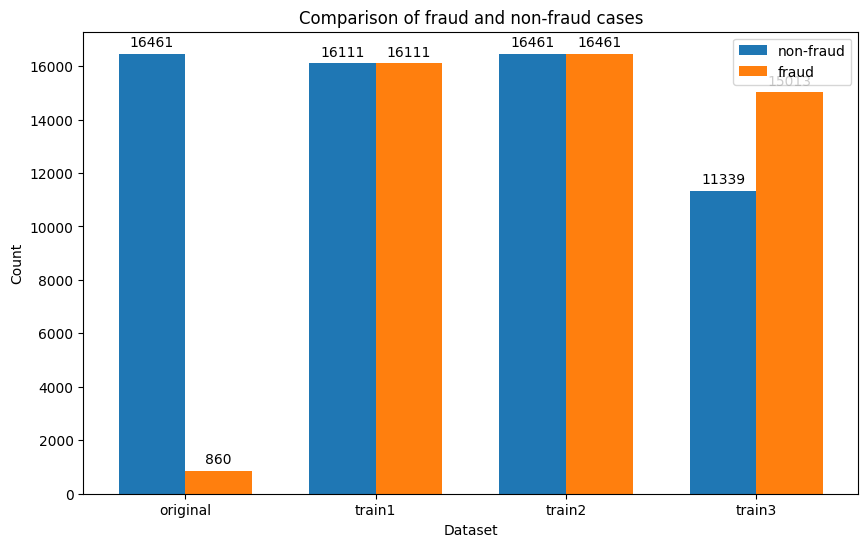

In [35]:
counts = [
    (y_train.value_counts(), 'original'),
    (y_train1.value_counts(), 'train1'),
    (y_train2.value_counts(), 'train2'),
    (y_train3.value_counts(), 'train3')
]

# Create the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(counts))
width = 0.35

# Plot the negative cases
non_fraud = ax.bar(x - width/2, [count[0].get(0, 0) for count in counts], width, label='non-fraud')

# Plot the positive cases
fraud = ax.bar(x + width/2, [count[0].get(1, 0) for count in counts], width, label='fraud')


# Add labels and title
ax.set_xticks(x)
ax.set_xticklabels([count[1] for count in counts])
ax.set_xlabel('Dataset')
ax.set_ylabel('Count')
ax.set_title('Comparison of fraud and non-fraud cases')
ax.legend()

for bar in non_fraud + fraud:
    height = bar.get_height()
    ax.annotate('{}'.format(int(height)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
plt.show()

## ML process

### We chose to use f2 score over f1 score in comparing our models

In [78]:
# Make scorer
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)
f2_scorer = make_scorer(f2_score)

In [ ]:
# Create StratifiedKFold for cross-validation with reduced splits
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

scoring_metrics = {
    'f2': f2_scorer,
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'pr_auc': make_scorer(average_precision_score)
}


### 1) Using Logistic Regression

#### we use the default LR model to compare between using standardized or normalized data

In [22]:
# Comparing performance of standardized and nominalized datasets for method 1 (SMOTE + Tomak's Link)

# Initialize logistic regression model
LR = LogisticRegression()

# Perform cross-validation (std)
cross_val_results_std = cross_val_score(LR, X_train1_standardized, y_train1, cv=5, scoring=f2_scorer)

# Print cross-validation F2 score (std)
print("Cross-Validation F2 Scores:", cross_val_results_std)
print("Mean F2 Score:", cross_val_results_std.mean())

Cross-Validation F2 Scores: [0.77783576 0.9631173  0.97360248 0.97259338 0.96291457]
Mean F2 Score: 0.9300126974047667


In [23]:
# Perform cross-validation (nom)
cross_val_results_nom = cross_val_score(LR, X_train1_normalized, y_train1, cv=5, scoring=f2_scorer)

# Print cross-validation F2 score (nom)
print("Cross-Validation F2 Scores:", cross_val_results_nom)
print("Mean F2 Score:", cross_val_results_nom.mean())

# We pick standardising over norminalizing given its slightly better mean F2 score

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Cross-Validation F2 Scores: [0.77397663 0.96266335 0.97354202 0.97134154 0.96322569]
Mean F2 Score: 0.928949843279765


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [89]:
# Initialize logistic regression model
LR = LogisticRegression()

param_grid_LR = [    
    {'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 2500]
    }
]

# Perform RandomizedSearchCV with reduced iterations
LR_randomized = RandomizedSearchCV(
    LR,
    param_distributions=param_grid_LR,
    n_iter=3,
    cv=skf,
    scoring=f2_scorer,
    random_state=seed,
    n_jobs=-1,
    verbose = True
)

cv_LR_m1 = cross_validate(LR_randomized, X_train1_standardized, y_train1, cv=skf, scoring=scoring_metrics)

for metric, score in cv_LR_m1.items():
    print(f"Mean {metric.upper()}: {np.mean(score)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean FIT_TIME: 84.70152441660564
Mean SCORE_TIME: 0.013197024663289389
Mean TEST_F2: 0.9343133549023314
Mean TEST_PRECISION: 0.9748086389616039
Mean TEST_ACCURACY: 0.9504065361319635
Mean TEST_ROC_AUC: 0.950406550293487
Mean TEST_PR_AUC: 0.9390610619080602


In [90]:
cv_LR_m2 = cross_validate(LR_randomized, X_train2_standardized, y_train2, cv=skf, scoring=scoring_metrics)

for metric, score in cv_LR_m2.items():
    print(f"Mean {metric.upper()}: {np.mean(score)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean FIT_TIME: 83.74887657165527
Mean SCORE_TIME: 0.011704285939534506
Mean TEST_F2: 0.934664671198577
Mean TEST_PRECISION: 0.9752839389698621
Mean TEST_ACCURACY: 0.9507927829414982
Mean TEST_ROC_AUC: 0.9507927829414982
Mean TEST_PR_AUC: 0.9396535977116375


In [91]:
cv_LR_m3 = cross_validate(LR_randomized, X_train3_standardized, y_train3, cv=skf, scoring=scoring_metrics)

for metric, score in cv_LR_m3.items():
    print(f"Mean {metric.upper()}: {np.mean(score)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean FIT_TIME: 70.97663633028667
Mean SCORE_TIME: 0.010557730992635092
Mean TEST_F2: 0.9400098255533615
Mean TEST_PRECISION: 0.9767434235566091
Mean TEST_ACCURACY: 0.9482012750455374
Mean TEST_ROC_AUC: 0.9509460937334623
Mean TEST_PR_AUC: 0.9487634336919667


### 2) Using SVM 

#### SVM was split into 3 cells otherwise it takes too long to run

In [ ]:
# Create an SVM classifier
SVM = svm.SVC(kernel='linear', random_state=seed)

cross_val_results_m1_SVM = cross_val_score(SVM, X_train1_standardized, y_train1, cv=5, scoring=f2_scorer)
print("Cross-Validation F2 Scores:", cross_val_results_m1_SVM)
print(f"Mean F2 Score: {cross_val_results_m1_SVM.mean()}\n")


Cross-Validation F2 Scores: [0.78952492 0.96699138 0.97410642 0.97341843 0.96563062]
Mean F2 Score: 0.9339343542360814



In [ ]:
cross_val_results_m2_SVM = cross_val_score(SVM, X_train2_standardized, y_train2, cv=5, scoring=f2_scorer)
print("Cross-Validation F2 Scores:", cross_val_results_m2_SVM)
print(f"Mean F2 Score: {cross_val_results_m2_SVM.mean()}\n")

Cross-Validation F2 Scores: [0.79581484 0.96610581 0.97460452 0.97270246 0.9656952 ]
Mean F2 Score: 0.9339343542360814



In [ ]:
cross_val_results_m3_SVM = cross_val_score(SVM, X_train3_standardized, y_train3, cv=5, scoring=f2_scorer)
print("Cross-Validation F2 Scores:", cross_val_results_m3_SVM)
print(f"Mean F2 Score: {cross_val_results_m3_SVM.mean()}\n")

Cross-Validation F2 Scores: [0.79550202 0.96894825 0.97749367 0.97565855 0.96751601]
Mean F2 Score: 0.9339343542360814



### 3) Using GBM

In [86]:
# Create a LightGBM classifier
GBM = lgb.LGBMClassifier(force_row_wise=True, verbose=-1,  random_state=seed)

param_grid_GBM = {
    'num_leaves': [31, 50, 70, 90, 127],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'min_child_samples': [20, 50, 100, 300],
    'min_child_weight': [0.001, 0.01, 0.1, 1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1, 2, 5],
    'reg_lambda': [0, 0.1, 1, 2, 5]
}


GBM_randomized = RandomizedSearchCV(
    GBM,
    param_distributions=param_grid_GBM,
    n_iter=3,
    cv=skf,
    scoring=f2_scorer,
    random_state=seed,
    n_jobs=-1,
    verbose = True
)


cv_GBM_m1 = cross_validate(GBM_randomized, X_train1_standardized, y_train1, cv=skf, scoring=scoring_metrics)

for metric, score in cv_GBM_m1.items():
    print(f"Mean {metric.upper()}: {np.mean(score)}")


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean FIT_TIME: 3.443812052408854
Mean SCORE_TIME: 0.04821364084879557
Mean TEST_F2: 0.9631372107115617
Mean TEST_PRECISION: 0.9822584989452366
Mean TEST_ACCURACY: 0.9705790813795229
Mean TEST_ROC_AUC: 0.9705790725441051
Mean TEST_PR_AUC: 0.9622310210501199


In [87]:
cv_GBM_m2 = cross_validate(GBM_randomized, X_train2_standardized, y_train2, cv=skf, scoring=scoring_metrics)

for metric, score in cv_GBM_m2.items():
    print(f"Mean {metric.upper()}: {np.mean(score)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean FIT_TIME: 3.474242607752482
Mean SCORE_TIME: 0.05310869216918945
Mean TEST_F2: 0.9622290299604366
Mean TEST_PRECISION: 0.9809657804299898
Mean TEST_ACCURACY: 0.9695340501792115
Mean TEST_ROC_AUC: 0.9695340501792115
Mean TEST_PR_AUC: 0.960601511590645


In [88]:
cv_GBM_m3 = cross_validate(GBM_randomized, X_train3_standardized, y_train3, cv=skf, scoring=scoring_metrics)

for metric, score in cv_GBM_m3.items():
    print(f"Mean {metric.upper()}: {np.mean(score)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean FIT_TIME: 2.948671499888102
Mean SCORE_TIME: 0.044251600901285805
Mean TEST_F2: 0.9671805995652155
Mean TEST_PRECISION: 0.9775311531138434
Mean TEST_ACCURACY: 0.9672131147540983
Mean TEST_ROC_AUC: 0.9676315116547741
Mean TEST_PR_AUC: 0.9631034028607249


### 4) Using Random Forest

In [83]:
RF = RandomForestClassifier(n_estimators=100, random_state=seed)

param_grid_RF = {
    'n_estimators':[100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 15, 20, 25, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

RF_randomized = RandomizedSearchCV(
    RF,
    param_distributions=param_grid_RF,
    n_iter=3,
    cv=skf,
    scoring=f2_scorer,
    random_state=seed,
    n_jobs=-1,
    verbose = True
)


cv_RF_m1 = cross_validate(RF_randomized, X_train1_standardized, y_train1, cv=skf, scoring=scoring_metrics)

for metric, score in cv_RF_m1.items():
    print(f"Mean {metric.upper()}: {np.mean(score)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean FIT_TIME: 27.650081237157185
Mean SCORE_TIME: 0.34339269002278644
Mean TEST_F2: 0.9707066808890271
Mean TEST_PRECISION: 0.9749814155220008
Mean TEST_ACCURACY: 0.9723791130605149
Mean TEST_ROC_AUC: 0.9723792371404886
Mean TEST_PR_AUC: 0.9605601798546438


In [84]:
cv_RF_m2 = cross_validate(RF_randomized, X_train2_standardized, y_train2, cv=skf, scoring=scoring_metrics)

for metric, score in cv_RF_m2.items():
    print(f"Mean {metric.upper()}: {np.mean(score)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean FIT_TIME: 27.873144547144573
Mean SCORE_TIME: 0.3575012683868408
Mean TEST_F2: 0.9711662844851198
Mean TEST_PRECISION: 0.9764073873735967
Mean TEST_ACCURACY: 0.9732094040459267
Mean TEST_ROC_AUC: 0.9732094040459267
Mean TEST_PR_AUC: 0.9620503199753777


In [85]:
cv_RF_m3 = cross_validate(RF_randomized, X_train3_standardized, y_train3, cv=skf, scoring=scoring_metrics)

for metric, score in cv_RF_m3.items():
    print(f"Mean {metric.upper()}: {np.mean(score)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean FIT_TIME: 21.540926615397137
Mean SCORE_TIME: 0.26586437225341797
Mean TEST_F2: 0.9736070071298841
Mean TEST_PRECISION: 0.9622583395401043
Mean TEST_ACCURACY: 0.9647844565877354
Mean TEST_ROC_AUC: 0.9628885038666978
Mean TEST_PR_AUC: 0.9530283950019086


### 5) Using ADA boost

In [80]:
ADA = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)

param_grid_ADA = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.5, 1.0]
}

ADA_randomized = RandomizedSearchCV(
    ADA,
    param_distributions=param_grid_ADA,
    n_iter=3,
    cv=skf,
    scoring=f2_scorer,
    random_state=seed,
    n_jobs=-1,
    verbose = True
)

cv_ADA_m1 = cross_validate(ADA_randomized, X_train1_standardized, y_train1, cv=skf, scoring=scoring_metrics)

for metric, score in cv_ADA_m1.items():
    print(f"Mean {metric.upper()}: {np.mean(score)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Mean FIT_TIME: 39.2658744653066
Mean SCORE_TIME: 0.549990733464559
Mean TEST_F2: 0.9453500022240268
Mean TEST_PRECISION: 0.9741055459284329
Mean TEST_ACCURACY: 0.9567376374059012
Mean TEST_ROC_AUC: 0.9567377729515281
Mean TEST_PR_AUC: 0.9449103152368141


In [81]:
cv_ADA_m2 = cross_validate(ADA_randomized, X_train2_standardized, y_train2, cv=skf, scoring=scoring_metrics)

for metric, score in cv_ADA_m2.items():
    print(f"Mean {metric.upper()}: {np.mean(score)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Mean FIT_TIME: 40.8813308874766
Mean SCORE_TIME: 0.632824977238973
Mean TEST_F2: 0.9451257589752241
Mean TEST_PRECISION: 0.9732867489754997
Mean TEST_ACCURACY: 0.9562906263288986
Mean TEST_ROC_AUC: 0.9562906263288986
Mean TEST_PR_AUC: 0.9441035841432409


In [82]:
cv_ADA_m3 = cross_validate(ADA_randomized, X_train3_standardized, y_train3, cv=skf, scoring=scoring_metrics)

for metric, score in cv_ADA_m3.items():
    print(f"Mean {metric.upper()}: {np.mean(score)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Mean FIT_TIME: 32.54342325528463
Mean SCORE_TIME: 0.49530752499898273
Mean TEST_F2: 0.9523508000264767
Mean TEST_PRECISION: 0.9705378071125846
Mean TEST_ACCURACY: 0.9539313904068002
Mean TEST_ROC_AUC: 0.9549067090678469
Mean TEST_PR_AUC: 0.9496617395889745


## Model Evaluation

#### We note that random forest performs best from our cross validation with all 3 datasets, hence will will be focusing on tuning that model

In [98]:
RF_m1 = RF_randomized.fit(X_train1_standardized, y_train1)
best_model_m1 = RF_randomized.best_estimator_
best_model_m1.fit(X_train1_standardized, y_train1)
y_pred_m1 = best_model_m1.predict(X_test1_standardized)

f2_score = fbeta_score(y_test1, y_pred_m1, beta=2)
print(f'F2 score: {f2_score}')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
F2 score: 0.151356993736952


In [99]:
RF_m2 = RF_randomized.fit(X_train2_standardized, y_train2)
best_model_m2 = RF_randomized.best_estimator_
best_model_m2.fit(X_train2_standardized, y_train2)
y_pred_m2 = best_model_m2.predict(X_test1_standardized)
f2_score = fbeta_score(y_test1, y_pred_m2, beta=2)
print(f'F2 score: {f2_score}')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
F2 score: 0.2351851851851852


In [100]:
RF_m3 = RF_randomized.fit(X_train3_standardized, y_train3)
best_model_m3 = RF_randomized.best_estimator_
best_model_m3.fit(X_train3_standardized, y_train3)
y_pred_m3 = best_model_m3.predict(X_test3_standardized)
f2_score = fbeta_score(y_test3, y_pred_m3, beta=2)
print(f'F2 score: {f2_score}')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
F2 score: 0.27631578947368424
